In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.stats import nbinom, gamma, fisher_exact
from scipy.special import digamma
from scipy.optimize import minimize
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


<h1> Helper Functions </h1>  

In [2]:
def download_faer_files(root_dir):
    # Defines root directory where FAERS datasets are located
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    # Adjusts range of files to download (can be 2012 to 2025) 
    all_quarters = [f"{str(y)[2:]}{q}" for y in range(2016, 2022) for q in quarters]

    # Limits to only those quarters that exist (sanity check)
    existing_quarters = [q for q in all_quarters if os.path.exists(os.path.join(root_dir, f"DEMO{q}.txt"))]

    # Stores DataFrames in a dict
    data = {}

    for q in existing_quarters:
        try:
            data[q] = {
                'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'reac': pd.read_csv(os.path.join(root_dir, f"REAC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'outc': pd.read_csv(os.path.join(root_dir, f"OUTC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'indi': pd.read_csv(os.path.join(root_dir, f"INDI{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'rpsr': pd.read_csv(os.path.join(root_dir, f"RPSR{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
            }
            print(f"Loaded {q} successfully.")
        except Exception as e:
            print(f"Error loading data for {q}: {e}")
    return data



In [3]:
def generate_periods(start_year, start_quarter, end_year, end_quarter):
    periods = []
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    start_year = int(start_year)
    end_year = int(end_year)

    # Loops through the years and quarters to generate all periods in the range
    for year in range(start_year, end_year + 1):
        start_qtr = start_quarter if year == start_year else 'Q1'
        end_qtr = end_quarter if year == end_year else 'Q4'

        for qtr in quarters[quarters.index(start_qtr):quarters.index(end_qtr) + 1]:
            periods.append(f"{str(year)[-2:]}{qtr}")
    return periods


In [4]:
def create_dataframes(start_year, start_quarter, end_year, end_quarter):
    # Generates periods based on user input
    periods = generate_periods(start_year, start_quarter, end_year, end_quarter)
    print(periods)

    # Lists of table types to be processed 
    table_types = ['demo', 'drug', 'reac', 'outc', 'indi', 'rpsr', 'ther']

    # Initializes a dictionary to store lists of DataFrames for each table
    data_dict = {table: [] for table in table_types}

    # Loops through each period and collect data for each table type
    for period in periods:
        if period in data:  # Check if data for the period exists
            for table in table_types:
                if table in data[period]:
                    data_dict[table].append(data[period][table])
        else:
            print(f"Warning: No data available for {period}")

    # Concatenates data for each table type into a single DataFrame
    merged_data = {
        table: pd.concat(data_dict[table], ignore_index=True) if data_dict[table] else pd.DataFrame()
        for table in table_types
    }

    demo = merged_data['demo']
    drug = merged_data['drug']
    reac = merged_data['reac']
    outc = merged_data['outc']
    indi = merged_data['indi']
    rpsr = merged_data['rpsr']
    ther = merged_data['ther']

    return demo, drug, reac, outc, indi, rpsr, ther


In [5]:
def preprocess_drug_df(drug):
    drug = drug[['primaryid', 'caseid', 'role_cod', 'drugname', 'prod_ai', 'drug_seq', 'dechal', 'rechal']]
    
    print("Starting number of reports in 'drug' file: ", drug.shape[0]) 
    
    drug = drug[drug['role_cod'] == 'PS']
    
    print("Number of reports in the 'drug' file where drug is the primary suspect: ", drug.shape[0]) 

    drug = drug[pd.notnull(drug['drugname'])]  # Drops Nulls
    drug = drug[~drug['drugname'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'drug' file after unknown/null drugs are removed: ", drug.shape[0]) 
    
    drug['drugname'] = drug['drugname'].str.strip().str.lower()  # Stips whitespace, Transforms to lowercase
    drug['drugname'] = drug['drugname'].str.replace('\\', '/')  # Standardizes slashes to '/'
    drug['drugname'] = drug['drugname'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    drug['prod_ai'] = drug['prod_ai'].str.lower()
    
    return drug


In [6]:
def preprocess_reac_df(reac):
    print("Starting number of reports in 'reac' file: ", reac.shape[0]) 

    reac = reac[pd.notnull(reac['pt'])] # Drops Nulls
    reac = reac[~reac['pt'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'reac' file after unknown/null reacs are removed: ", reac.shape[0]) 

    reac['pt'] = reac['pt'].str.strip().str.lower()  # Transforms to lowercase
    reac['pt'] = reac['pt'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    return reac


In [7]:
def preprocess_demo_df(demo):
    print("Starting number of reports in 'demo' file: ", demo.shape[0]) 

    demo = demo[['primaryid', 'caseid', 'caseversion', 'age_cod', 'age', 'sex', 'wt', 'fda_dt', 'event_dt']] 
    
    # If multiple reports have the same primary id and case id, keep the most recent one 
    demo = demo.sort_values(by=['caseid', 'fda_dt', 'primaryid'], ascending=[True, False, False])
    demo = demo.drop_duplicates(subset=['caseid'], keep='first')
    
    print("Number of reports in the 'demo' file after duplicate primary/case id combos are removed: ", demo.shape[0]) 

    demo = demo[pd.notnull(demo['age'])]
    demo = demo[demo.age_cod != 'dec'].reset_index(drop=True)
    demo['age'] = demo['age'].apply(pd.to_numeric, errors='coerce')
    demo['age'] = np.where(demo['age_cod'] == 'MON', demo['age'] * 1 / 12, demo['age'])  # mounth
    demo['age'] = np.where(demo['age_cod'] == 'WK', demo['age'] * 1 / 52, demo['age'])  # week
    demo['age'] = np.where(demo['age_cod'] == 'DY', demo['age'] * 1 / 365, demo['age'])  # day
    demo['age'] = np.where(demo['age_cod'] == 'HR', demo['age'] * 1 / 8760, demo['age'])  # hour
    demo = demo.drop(['age_cod'], axis=1)

    print("Number of reports in the 'demo' file after unknown/invalid ages are removed: ", demo.shape[0]) 


    return demo


In [8]:
def preprocess_ther_df(ther):
    print("Starting number of reports in 'ther' file: ", ther.shape[0]) 

    ther = ther[['primaryid', 'caseid', 'start_dt', 'dsg_drug_seq']] 

    ther = ther.rename(columns={'dsg_drug_seq': 'drug_seq'})

    return ther


In [9]:
def phv_ebgm_qn(theta_hat, N, E):
    r1, b1, r2, b2, p = theta_hat
    prob_f1 = b1 / (b1 + E)
    prob_f2 = b2 / (b2 + E)
    f1_nb = nbinom.pmf(N, n=r1, p=prob_f1)
    f2_nb = nbinom.pmf(N, n=r2, p=prob_f2)
    num = p * f1_nb
    den = num + (1 - p) * f2_nb
    return num / den

def phv_ebgm_score(theta_hat, N, E, qn):
    r1, b1, r2, b2, _ = theta_hat
    e1 = digamma(r1 + N) - np.log(b1 + E)
    e2 = digamma(r2 + N) - np.log(b2 + E)
    exp_log = qn * e1 + (1 - qn) * e2
    eb_log2 = exp_log / np.log(2)
    return 2 ** eb_log2

def phv_ebgm_quant_bisect(cut_point, theta_hat, N, E, qn,
                          digits=2, limits=(-1e5, 1e5), max_iter=2000):
    r1, b1, r2, b2, _ = theta_hat
    lower, upper = limits
    tol = 0.5 * 10 ** (-digits)

    def post_cdf_minus_cp(x):
        c1 = gamma.cdf(x, a=r1 + N, scale=1/(b1 + E))
        c2 = gamma.cdf(x, a=r2 + N, scale=1/(b2 + E))
        return qn * c1 + (1 - qn) * c2 - cut_point

    N = np.asarray(N)
    E = np.asarray(E)
    qn = np.asarray(qn)

    guess = np.ones_like(N, dtype=float)
    err0 = post_cdf_minus_cp(guess)
    is_pos = err0 > 0
    left = np.where(is_pos, lower, guess)
    right = np.where(is_pos, guess, upper)

    for _ in range(max_iter):
        mid = (left + right) / 2
        err_mid = post_cdf_minus_cp(mid)
        if np.max((right - left) / 2) < tol:
            q = np.round(mid, digits)
            if np.any(q == upper):
                raise ValueError("increase maximum for 'limits'")
            return q
        err_left = post_cdf_minus_cp(left)
        same = np.sign(err_left) == np.sign(err_mid)
        left = np.where(same, mid, left)
        right = np.where(same, right, mid)

    raise RuntimeError("failed to converge -- try adjusting 'limits' or 'max_iter'")

def dbinbinom(x, size1, prob1, size2, prob2, w):
    return w * nbinom.pmf(x, n=size1, p=prob1) + (1 - w) * nbinom.pmf(x, n=size2, p=prob2)

def phvid_objective(theta, N, E):
    r1, b1, r2, b2, w = theta
    prob1 = b1 / (b1 + E)
    prob2 = b2 / (b2 + E)
    pmf = dbinbinom(N, r1, prob1, r2, prob2, w)
    return np.sum(-np.log(pmf + 1e-16))  # add tiny epsilon to avoid log(0)

def phv_ebgm(a, b, c, d, alpha=0.05, theta_init=None, squashing=True):
    """
    a, b, c, d: counts (scalars or array‐like)
    alpha: two‐sided significance level
    theta_init: array‐like [r1, b1, r2, b2, p] or pandas.DataFrame of guesses
    squashing: (not implemented – placeholder)
    """
    # turn inputs into arrays
    a, b, c, d = np.broadcast_arrays(a, b, c, d)
    if np.any(a < 0) or np.any(b < 0) or np.any(c < 0) or np.any(d < 0):
        raise ValueError("a, b, c, d must be non‐negative")
    # total counts
    tot = a + b + c + d
    N = a.astype(float)
    E = (a + b) / tot * (a + c)

    # squashing placeholder
    if squashing and np.any(a == 0):
        warnings.warn("squashing=True but no squash implemented; continuing with raw counts")

    # prepare initial guess
    if theta_init is None:
        x0 = np.array([0.2, 0.1, 2.0, 4.0, 1/3])
    else:
        if isinstance(theta_init, pd.DataFrame):
            x0 = theta_init.iloc[0].values
        else:
            x0 = np.asarray(theta_init, dtype=float)
        if x0.shape[0] != 5:
            raise ValueError("theta_init must have length 5")

    # bounds: r1,b1,r2,b2 > 0; p in (0,1)
    bounds = [(1e-6, None)]*4 + [(1e-6, 1-1e-6)]
    res = minimize(phvid_objective, x0, args=(N, E),
                   bounds=bounds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("hyperparameter estimation failed: " + res.message)
    theta_hat = res.x

    # compute posterior weights, EBGM and CIs
    qn = phv_ebgm_qn(theta_hat, N, E)
    ebgm = phv_ebgm_score(theta_hat, N, E, qn)
    half = alpha / 2
    ci_low  = phv_ebgm_quant_bisect(half,      theta_hat, N, E, qn)
    ci_high = phv_ebgm_quant_bisect(1 - half,  theta_hat, N, E, qn)

    return pd.DataFrame({
        'ebgm':   ebgm,
        'ci_low': ci_low,
        'ci_high':ci_high
    })

In [10]:
def compute_or_and_ci(a, b, c, d):
    """
    Computes Odds Ratio (OR) and Confidence Interval (CI)
    """
    # Odds Ratio
    or_val = (a * d) / (b * c)

    # Log(OR) and standard error
    log_or = np.log(or_val)
    se = np.sqrt(1 / a + 1 / b + 1 / c + 1 / d)

    # Confidence Interval
    ci_low = np.exp(log_or - 1.96 * se)
    ci_high = np.exp(log_or + 1.96 * se)

    return or_val, ci_low, ci_high


def compute_prr_and_ci(a, b, c, d):
    """ 
    Computes Proportional Reporting Ratio (PRR), Standard Error (SE), and Confidence Interval (CI)
    """ 
    # Proportional Reporting Ratio (PRR)
    prr = (a / (a + b)) / (c / (c + d))
    
    # Log of PRR
    ln_prr = np.log(prr)

    # Standard Error (SE) of ln(PRR)
    se = np.sqrt(1/a - 1/(a + b) + 1/c - 1/(c + d))
    
    # Confidence Interval for PRR
    ci_low = np.exp(ln_prr - 1.96 * se)
    ci_high = np.exp(ln_prr + 1.96 * se)

    return prr, ci_low, ci_high

def compute_ic_and_ic025(a, b, c, d,
                        gamma_11=0.5, alpha1=0.5, beta1=0.5, 
                        alpha=2.0, beta=2.0):
    """
    Compute Bayesian Information Component (IC) and lower bound IC025
    
    Parameters:
        a, b, c, d: int or float (counts in 2x2 contingency table)
        gamma_11, alpha1, beta1, alpha, beta: prior hyperparameters
    
    Returns:
        E_IC: Expected IC value (mean)
        IC025: Lower bound of 95% credibility interval (IC - 2*std)
    """
    a, b, c, d = map(np.asarray, (a, b, c, d))
    
    N = a + b + c + d
    gamma = gamma_11 * (N + alpha) * (N + beta) / ((a + b + alpha1) * (a + c + beta1))
    
    E_IC = np.log2(((a + gamma_11) * (N + alpha) * (N + beta)) /
                   ((N + gamma) * (a + b + alpha1) * (a + c + beta1)))
    
    ln2_sq = (np.log(2))**2
    term1 = (N - a + gamma - gamma_11) / ((a + gamma_11) * (1 + N + gamma))
    term2 = (N - (a + b) + alpha - alpha1) / ((a + b + alpha1) * (1 + N + alpha))
    term3 = (N - (a + c) + beta - beta1) / ((a + c + beta1) * (1 + N + beta))
    
    Var_IC = (1 / ln2_sq) * (term1 + term2 + term3)
    IC025 = E_IC - 2 * np.sqrt(Var_IC)
    
    return E_IC, IC025


In [11]:
# Function to add statistics (OR, PRR, EGBM) to the DataFrame
def add_stats(df):
    a = df['Count_query_drug'] 
    b = df['No_AE_query_drug'] 
    c = df['Count_non_query_drug'] 
    d = df['No_AE_non_query_drug'] 

    # Compute Odds Ratio (OR) and Confidence Interval (CI) 
    or_vals, ci_low_or, ci_high_or = compute_or_and_ci(a, b, c, d)

    # Compute Proportional Reporting Ratio (PRR), SE, and Confidence Interval (CI) 
    prr_vals, ci_low_prr, ci_high_prr = compute_prr_and_ci(a, b, c, d)

    p_values = []
    for i in range(len(df)):
        # Construct the 2x2 contingency table for the current event
        table = [[a[i], b[i]], [c[i], d[i]]]
        _, p_val_fisher = fisher_exact(table)
        p_values.append(p_val_fisher)

    # Apply Benjamini-Hochberg correction
    _, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Compute ic statistic 
    ic, ic_025 = compute_ic_and_ic025(a, b, c, d, gamma_11=0.5, alpha1=0.5, beta1=0.5, alpha=2.0, beta=2.0)

    # Compute ebgm statistic 
    ebgm_result = phv_ebgm(a, b, c, d, alpha=0.5)

    cols = []
    if 'soc_name' in df.columns:
        cols.append('soc_name')
    elif 'pt_name' in df.columns:
        cols.append('pt_name')
    cols.append('Count_query_drug')
    df_new = df[cols].copy()

    # Add new columns for OR, PRR, and p-value statistics
    df_new['ror'] = or_vals
    df_new['ci_low_ror'] = ci_low_or
    df_new['ci_high_ror'] = ci_high_or
    df_new['prr'] = prr_vals
    df_new['ci_lower_prr'] = ci_low_prr
    df_new['ci_upper_prr'] = ci_high_prr
    df_new['p_val_fisher'] = p_values
    df_new['ic'] = ic
    df_new['ic_025'] = ic_025

    df_new = df_new.merge(ebgm_result, left_index=True, right_index=True)

    return df_new

<h1>Loading Files and Preprocessing</h1>

In [12]:
root_dir = '/Users/jodie/Documents/BMI 212/faers-cohort-generation/FAERS-data-toolkit-master/FAERSdata'
data = download_faer_files(root_dir)


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 16Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 16Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 16Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 16Q4 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 17Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 17Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 17Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 17Q4 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 18Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 18Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 18Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 18Q4 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 19Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 19Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 19Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 19Q4 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 20Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 20Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 20Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 20Q4 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 21Q1 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 21Q2 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:18: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:23: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 21Q3 successfully.


/var/folders/1z/lz8g1zg14zv6dkhlyvsk7zvc0000gn/T/ipykernel_76435/2601739929.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 21Q4 successfully.


In [13]:
# Get start year/quarter and end year/quarter for querying 
start_year = 2016
start_quarter = 'Q1'
end_year = 2021
end_quarter = 'Q4'

demo, drug, reac, outc, indi, rpsr, ther = create_dataframes(start_year, start_quarter, end_year, end_quarter)


['16Q1', '16Q2', '16Q3', '16Q4', '17Q1', '17Q2', '17Q3', '17Q4', '18Q1', '18Q2', '18Q3', '18Q4', '19Q1', '19Q2', '19Q3', '19Q4', '20Q1', '20Q2', '20Q3', '20Q4', '21Q1', '21Q2', '21Q3', '21Q4']


In [14]:
demo = preprocess_demo_df(demo)
drug = preprocess_drug_df(drug)
reac = preprocess_reac_df(reac)
ther = preprocess_ther_df(ther)

Starting number of reports in 'demo' file:  9704337
Number of reports in the 'demo' file after duplicate primary/case id combos are removed:  8423297
Number of reports in the 'demo' file after unknown/invalid ages are removed:  4688586
Starting number of reports in 'drug' file:  39811910
Number of reports in the 'drug' file where drug is the primary suspect:  9704234
Number of reports in the 'drug' file after unknown/null drugs are removed:  9704232
Starting number of reports in 'reac' file:  30416465
Number of reports in the 'reac' file after unknown/null reacs are removed:  30416465
Starting number of reports in 'ther' file:  14742114


<h1>Drug Search, Merging, and Filtering</h1>

In [15]:
# More Configuration 
query_drug = 'osimertinib' 
min_age_yrs = 0
max_age_yrs = 100
min_AE_ct = 3 


In [16]:
# Finds reports related to the query drug
query_drug_df = drug[
    drug['drugname'].str.contains(query_drug, na=False) |
    drug['prod_ai'].str.contains(query_drug, na=False)
]

print(f"Number of reports for {query_drug} in 'drug' file/s: ", query_drug_df.shape[0])  

Number of reports for osimertinib in 'drug' file/s:  11871


In [17]:
# Merges with demo and outc
query_drug_df_merged = pd.merge(demo, query_drug_df, on=['primaryid', 'caseid'], how='inner') # Keep only rows with primaryids in both 'drug' and 'demo'
query_drug_df_merged = pd.merge(query_drug_df_merged, outc, on=['primaryid', 'caseid'], how='left') # Keep existing rows, also append 

print(f"Number of reports for {query_drug} with primary ids in 'drug' and 'demo' files: ", query_drug_df_merged.shape[0])  
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())  

Number of reports for osimertinib with primary ids in 'drug' and 'demo' files:  7692
Number of reports with same 'primaryid':  1515


In [18]:
# Filters by age range 
query_drug_df_merged = query_drug_df_merged[
    (query_drug_df_merged['age'] >= min_age_yrs) & 
    (query_drug_df_merged['age'] <= max_age_yrs)
]

print(f"Number of reports for {query_drug} that meet age range of interest: ", query_drug_df_merged.shape[0])
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())

Number of reports for osimertinib that meet age range of interest:  7692
Number of reports with same 'primaryid':  1515


<h1> Descriptive Stats (need to add) </h>

In [19]:
# Descriptive stats: Get sex breakdown 
counts = query_drug_df_merged['sex'].value_counts()
percentages = query_drug_df_merged['sex'].value_counts(normalize=True) * 100

summary_df = pd.DataFrame({'count': counts, 'percent': percentages.round(2)})
summary_df

,count,percent
sex,,
F,4737,63.75
M,2694,36.25


In [20]:
query_drug_df_merged.describe(include='all')


,primaryid,caseid,caseversion,age,sex,wt,fda_dt,event_dt,role_cod,drugname,prod_ai,drug_seq,dechal,rechal,outc_cod
count,7.692000e+03,7.692000e+03,7692.000000,7692.000000,7431,2583.000000,7.692000e+03,6.494000e+03,7692,7692,7692,7692.000000,5318,1221,7336
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,1,13,2,NaN,4,4,7
top,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,PS,tagrisso,osimertinib,NaN,U,U,DE
freq,NaN,NaN,NaN,NaN,4737,NaN,NaN,NaN,7692,6951,7584,NaN,2070,1018,3115
mean,1.726618e+08,1.698185e+07,1.741940,69.289092,NaN,57.036365,2.019456e+07,1.678249e+07,NaN,NaN,NaN,1.017681,NaN,NaN,NaN
std,6.165820e+07,2.287526e+06,1.322458,11.969755,NaN,16.727018,1.517340e+04,7.530376e+06,NaN,NaN,NaN,0.196046,NaN,NaN,NaN
min,8.834398e+07,8.834398e+06,1.000000,0.084932,NaN,22.900000,2.016010e+07,1.989000e+03,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,1.534621e+08,1.532412e+07,1.000000,61.708219,NaN,45.400000,2.018102e+07,2.016100e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
50%,1.749019e+08,1.747695e+07,1.000000,70.000000,NaN,55.000000,2.020033e+07,2.019030e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,1.885361e+08,1.884068e+07,2.000000,78.000000,NaN,65.000000,2.021023e+07,2.020100e+07,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


<h1> Contingency Table by Preferred Term (pt_name) </h>

In [21]:
# Get AE counts for cases where query drug is mentioned
query_drug_ids = query_drug_df_merged['primaryid'].unique()
query_drug_reac = reac[reac['primaryid'].isin(query_drug_ids)]
ae_counts = query_drug_reac['pt'].value_counts().reset_index()
ae_counts.columns = ['pt_name', 'Count']

# Get AE counts for cases where query drug is not mentioned
non_query_drug = drug[~drug['primaryid'].isin(query_drug_ids)]
non_query_ids = non_query_drug['primaryid'].unique()
non_query_reac = reac[reac['primaryid'].isin(non_query_ids)]
non_ae_counts = non_query_reac['pt'].value_counts().reset_index()
non_ae_counts.columns = ['pt_name', 'Count']

ae_counts.columns = ['pt_name', 'Count_query_drug']
non_ae_counts.columns = ['pt_name', 'Count_non_query_drug']

# Merge AE counts for query drug and non-query drug
ae_contingency = pd.merge(
    ae_counts,
    non_ae_counts,
    on='pt_name',
    how='outer'
)

# Filter to AEs with at least 'min_AE_ct' events for the query drug
ae_contingency = ae_contingency[
    (ae_contingency['Count_query_drug'].notna()) &
    (ae_contingency['Count_query_drug'] >= min_AE_ct)
].copy().reset_index() 
ae_contingency = ae_contingency.drop('index', axis=1)

if ae_contingency.empty:
    warnings.warn("Filtered AE dataset is empty — no AEs meet the criteria.", RuntimeWarning)

In [22]:
# Calculates the number of reports that did not include a specific adverse
# event for both the query drug and non-query drugs
query_num = query_drug_ids.shape[0]
non_num = non_query_ids.shape[0]
ae_contingency['No_AE_query_drug'] = query_num - ae_contingency['Count_query_drug']
ae_contingency['No_AE_non_query_drug'] = non_num - ae_contingency['Count_non_query_drug']

In [23]:
pt_stats = add_stats(ae_contingency.copy()) 

# Change to reflect path with file associating medra terms with soc terms 
root_dir = '/Users/jodie/Documents/BMI 212/faers-cohort-generation' 
llt_soc = pd.read_csv(os.path.join(root_dir, 'llt_soc.csv'))
llt_soc['pt_name'] = llt_soc['pt_name'].str.lower()
llt_soc = llt_soc[['pt_name', 'soc_name']].drop_duplicates()

pt_stats = pt_stats.merge(
    llt_soc[['pt_name', 'soc_name']],
    how='left',
    on=['pt_name']
)
cols = pt_stats.columns.tolist()
last_col = cols.pop(-1)           
cols.insert(1, last_col)         
pt_stats = pt_stats[cols]


In [24]:
pt_stats = pt_stats.sort_values(by='ror', ascending=False).head(10)
pt_stats

,pt_name,soc_name,Count_query_drug,ror,ci_low_ror,ci_high_ror,prr,ci_lower_prr,ci_upper_prr,p_val_fisher,ic,ic_025,ebgm,ci_low,ci_high
69,braf v600e mutation positive,Investigations,5.0,270.903636,104.829591,700.076947,270.685161,104.813780,699.053659,2.859045e-11,3.397413,2.072126,79.310829,60.36,107.78
5,acquired gene mutation,"Congenital, familial and genetic disorders",114.0,229.342527,188.164489,279.531995,225.128338,185.298961,273.518903,4.209524e-218,6.729527,6.441063,183.390731,172.32,195.49
189,egfr gene mutation,"Congenital, familial and genetic disorders",25.0,169.132617,111.880587,255.681911,168.452139,111.599033,254.268540,3.899729e-46,5.261952,4.661917,120.990258,106.22,138.81
363,malignant transformation,"Neoplasms benign, malignant and unspecified (i...",31.0,168.666253,116.362990,244.478977,167.824800,115.977673,242.849877,8.817153e-57,5.482267,4.942321,125.608989,111.69,142.09
356,lymphangiosis carcinomatosa,"Neoplasms benign, malignant and unspecified (i...",32.0,96.925283,67.768736,138.626026,96.428342,67.539229,137.674433,3.152119e-51,5.252837,4.730769,81.309119,72.43,91.79
462,pericardial effusion malignant,Cardiac disorders,4.0,76.633072,28.081211,209.130145,76.584094,28.080676,208.866893,3.340824e-07,3.019194,1.623594,42.600534,31.57,60.04
426,non-small cell lung cancer recurrent,"Neoplasms benign, malignant and unspecified (i...",4.0,71.408045,26.208260,194.561138,71.362452,26.207803,194.316153,4.382445e-07,3.009301,1.615939,41.005227,30.39,57.81
378,metastases to meninges,"Neoplasms benign, malignant and unspecified (i...",42.0,68.155701,49.993641,92.915809,67.699081,49.759192,92.106915,1.613279e-60,5.211396,4.758153,61.097479,55.21,67.91
597,trousseau's syndrome,NaN,5.0,56.518823,23.151517,137.977021,56.473883,23.149256,137.771139,4.662662e-08,3.215790,1.961723,38.398389,29.23,52.21
585,thrombophlebitis migrans,Vascular disorders,4.0,52.805781,19.491408,143.060495,52.772233,19.491200,142.880308,1.401677e-06,2.959237,1.574006,34.330133,25.47,48.47


In [25]:
pt_stats.to_csv(f"pt_terms_{query_drug}.csv", index=False)


<h1> Contingency Table by SOC Term (soc_name) </h>

In [26]:
soc_contingency = (
    ae_contingency
    .merge(llt_soc[['pt_name', 'soc_name']], how='left', on='pt_name')
    .groupby('soc_name', as_index=False)
    .agg({
        'Count_query_drug': 'sum',
        'Count_non_query_drug': 'sum',
        'No_AE_query_drug': 'sum',
        'No_AE_non_query_drug': 'sum'
    })
)
soc_contingency.head(5)

,soc_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
0,Blood and lymphatic system disorders,419.0,355668,104590.0,164505725
1,Cardiac disorders,596.0,508166,271192.0,426191910
2,"Congenital, familial and genetic disorders",146.0,2100,18385.0,29091087
3,Ear and labyrinth disorders,24.0,94488,24684.0,38696428
4,Endocrine disorders,16.0,25360,18515.0,29067827


In [27]:
soc_stats = add_stats(soc_contingency.copy())

In [28]:
soc_stats = soc_stats.sort_values(by='ror', ascending=False)
soc_stats.head(10)

,soc_name,Count_query_drug,ror,ci_low_ror,ci_high_ror,prr,ci_lower_prr,ci_upper_prr,p_val_fisher,ic,ic_025,ebgm,ci_low,ci_high
2,"Congenital, familial and genetic disorders",146.0,110.009420,92.961851,130.183215,109.150569,92.350669,129.006609,4.807000e-235,6.246124,5.999175,101.264414,95.83,107.14
15,"Neoplasms benign, malignant and unspecified (i...",1267.0,6.816809,6.449868,7.204627,6.785412,6.422071,7.169309,0.000000e+00,2.753853,2.672415,6.759843,6.64,6.89
8,Hepatobiliary disorders,307.0,3.097570,2.768957,3.465183,3.091055,2.764094,3.456691,1.674154e-62,1.621281,1.456320,3.042586,2.93,3.16
17,Product issues,3.0,2.438546,0.785561,7.569763,2.437848,0.785767,7.563436,1.273922e-01,1.014801,-0.529334,1.433070,1.07,1.97
20,"Respiratory, thoracic and mediastinal disorders",1618.0,2.207633,2.102337,2.318202,2.202179,2.097606,2.311965,8.662257e-174,1.137291,1.065358,2.196469,2.16,2.23
13,Metabolism and nutrition disorders,498.0,2.040317,1.868285,2.228189,2.035657,1.864754,2.222224,8.939656e-46,1.023040,0.893435,2.023704,1.96,2.09
0,Blood and lymphatic system disorders,419.0,1.852935,1.683324,2.039635,1.849531,1.680876,2.035110,2.559186e-30,0.884913,0.743673,1.838818,1.78,1.90
1,Cardiac disorders,596.0,1.843185,1.700760,1.997537,1.841336,1.699353,1.995182,8.135702e-42,0.878961,0.760622,1.833586,1.78,1.89
7,General disorders and administration site cond...,3796.0,1.515609,1.467823,1.564952,1.508868,1.461905,1.557338,1.573329e-125,0.592900,0.545744,1.507792,1.49,1.52
12,Investigations,876.0,1.248347,1.168214,1.333978,1.247629,1.167765,1.332954,2.369523e-10,0.318754,0.221115,1.246158,1.22,1.28


In [29]:
soc_stats.to_csv(f"soc_terms_{query_drug}.csv", index=False)

<h1> Time-to-Onset Visualizations </h1> 

In [30]:
def prepare_merged_ther_df(ther, query_drug_df_merged, query_drug):
    """
    Merge 'ther' and 'query_drug_df_merged' DataFrames on ['primaryid', 'caseid', 'drug_seq'],
    clean and convert 'start_dt' and 'event_dt' columns to datetime, remove incomplete or invalid dates, 
    and filter rows where event date is before start date.

    Parameters:
        ther (pd.DataFrame): Therapy data
        query_drug_df_merged (pd.DataFrame): Drug data
        query_drug (str): Drug name or label for printing info

    Returns:
        pd.DataFrame: Cleaned merged DataFrame
    """
    # Merge
    merged_df = pd.merge(ther, query_drug_df_merged, on=['primaryid', 'caseid', 'drug_seq'], how='inner')
    print(f"Number of reports for {query_drug} with ids in 'drug', 'demo', and 'ther' files: {merged_df.shape[0]}")

    # Extract and convert start_dt
    start_dt_str = merged_df['start_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['start_dt'] = pd.to_datetime(start_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['start_dt'])

    # Extract and convert event_dt
    event_dt_str = merged_df['event_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['event_dt'] = pd.to_datetime(event_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['event_dt'])

    print("Number of reports after removal of incomplete dates:", merged_df.shape[0])

    # Remove rows where event_dt is before start_dt
    merged_df = merged_df[merged_df['event_dt'] >= merged_df['start_dt']]
    print("Number of reports after removal of invalid start/event times:", merged_df.shape[0])

    merged_df['time_to_onset'] = (
        merged_df['event_dt'] - merged_df['start_dt']
    ).dt.days
    
    return merged_df

In [31]:
query_drug_df_merged_ther = prepare_merged_ther_df(ther, query_drug_df_merged, query_drug)

Number of reports for osimertinib with ids in 'drug', 'demo', and 'ther' files: 5760
Number of reports after removal of incomplete dates: 3992
Number of reports after removal of invalid start/event times: 3878


In [32]:
q1 = query_drug_df_merged_ther['time_to_onset'].quantile(0.25)
q2 = query_drug_df_merged_ther['time_to_onset'].quantile(0.5)
q3 = query_drug_df_merged_ther['time_to_onset'].quantile(0.75)
iqr = q3 - q1

print("Median time to onset in days:", q2)
print("Interquartile Range in days:", iqr)

Median time to onset in days: 44.0
Interquartile Range in days: 151.0


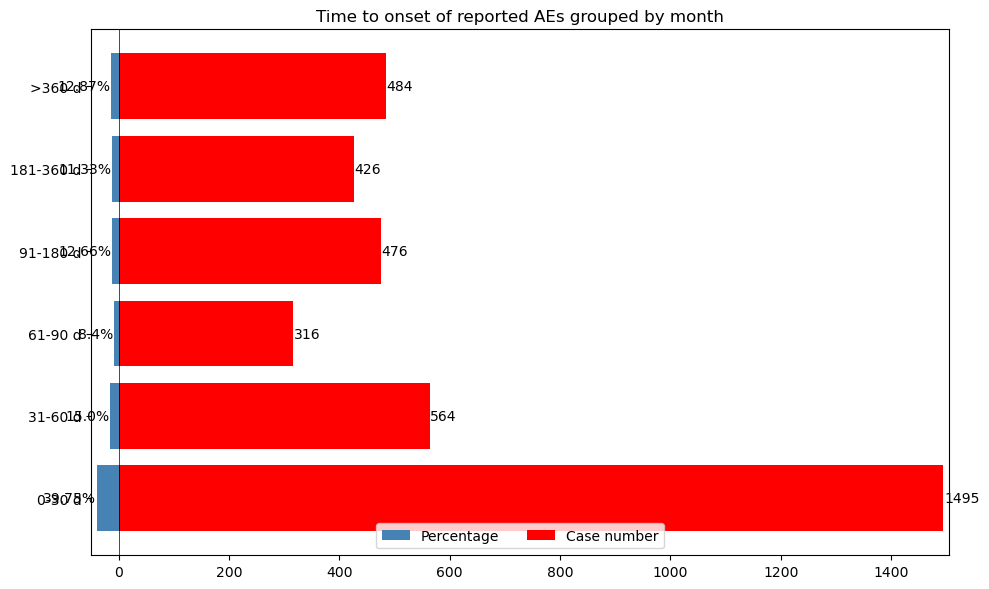

In [33]:
# Define onset bins and labels
bins = [0, 30, 60, 90, 180, 360, float('inf')]
labels = ['0-30 d', '31-60 d', '61-90 d', '91-180 d', '181-360 d', '>360 d']

# Bin the time_to_onset values
query_drug_df_merged_ther['onset_bin'] = pd.cut(
    query_drug_df_merged_ther['time_to_onset'],
    bins=bins,
    labels=labels,
    right=True
)

# Count and percentage
counts = query_drug_df_merged_ther['onset_bin'].value_counts().sort_index()
percentages = (counts / counts.sum() * 100).round(2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = range(len(labels))

# Plot percentages to the left (negative values)
ax.barh(y_pos, -percentages, color='steelblue', label='Percentage')

# Plot counts to the right
ax.barh(y_pos, counts, color='red', label='Case number')

# Add text labels
for i, (pct, count) in enumerate(zip(percentages, counts)):
    ax.text(-pct - 1, i, f"{pct}%", va='center', ha='right', color='black')
    ax.text(count + 1, i, str(count), va='center', ha='left', color='black')

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-max(percentages) - 10, max(counts) + 10)
ax.set_xlabel('')

# Title and legend
ax.set_title('Time to onset of reported AEs grouped by month')
ax.legend(loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

